# Clustering and Viz Experimentation

In [89]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
import os
import sys

module_path = os.path.abspath(os.path.join('rcnn/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans,MeanShift, AgglomerativeClustering

In [2]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

### importing datasets

In [3]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

class_dict = util.indexed_dictionary

tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
#tiles['028012'] = ['20110831']
#tiles['029011'] = ['20110831']
#tiles['028011'] = ['20110831']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets
    
tile_size = 5
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
clean_pixels_count = 3000000
max_count_per_class = 1001

### Training Data 

In [4]:
sk_data, sk_labels, class_count_dict = rnn_pixels.balanced_pix_data(landsat_datasets, lc_labels, canopy_labels, tile_size, tile_list, 
                           clean_pixels_count, class_count, max_count_per_class, class_dict, buffer_pix=1)

sk_data.shape, sk_labels.shape, class_count_dict

Beginning balanced data creation.
Clean pix generated, starting generator.
Iterating through data and clipping for balance.
Processing Complete.


((6006, 28), (6006, 2), {0: 1001, 1: 1001, 2: 1001, 3: 1001, 4: 1001, 5: 1001})

### Function for Splitting Data into Training and Testing Data

In [5]:
def sk_train_test_split(max_per_test_class, max_per_train_class, sk_data, sk_labels):

    # Create Test and Train Count Dictionary
    test_class_count_dict = {}
    train_class_count_dict = {}
    for key in class_dict:
        test_class_count_dict[key] = 0 
        train_class_count_dict[key] = 0

    # Training 
    sk_data_test = []
    sk_labels_test = []

    #Testing
    sk_data_train = []
    sk_labels_train = []

    for x in range(len(sk_data)):
        pop_data = sk_data[x]
        pop_label = sk_labels[x]
        pop_class = pop_label[0]
        if test_class_count_dict[pop_class] < max_per_test_class:
            sk_data_test.append(pop_data)
            sk_labels_test.append(pop_label)
            test_class_count_dict[pop_class] += 1
        elif train_class_count_dict[pop_class] < max_per_train_class:
            sk_data_train.append(pop_data)
            sk_labels_train.append(pop_label)
            train_class_count_dict[pop_class] += 1

    return(np.array(sk_data_train),np.array(sk_labels_train), np.array(sk_data_test), np.array(sk_labels_test),train_class_count_dict,test_class_count_dict)



In [6]:
# max_per_test_class = 100
# max_per_train_class = 300

# sk_data_train, sk_labels_train, sk_data_test, sk_labels_test, train_class_count_dict,test_class_count_dict = sk_train_test_split(max_per_test_class, max_per_train_class, sk_data, sk_labels)


# print(test_class_count_dict)
# print(train_class_count_dict)
# print(sk_data_train.shape)
# print(sk_data_test.shape)
# print(sk_labels_train.shape)
# print(sk_labels_test.shape)


{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
{0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300}
(1800, 28)
(600, 28)
(1800, 2)
(600, 2)


In [7]:
class_dict

{0: 'Water',
 1: 'Developed',
 2: 'Forest',
 3: 'Cultivated',
 4: 'Barren',
 5: 'Wetland'}

## Testing Input Size

In [8]:

max_count_per = []
scores = []
for x in range(10,900,10):
    max_count_per.append(x)
    
    # Split
    max_per_test_class = 100
    max_per_train_class = x

    sk_data_train, sk_labels_train, sk_data_test, sk_labels_test, train_class_count_dict,test_class_count_dict = sk_train_test_split(max_per_test_class, max_per_train_class, sk_data, sk_labels)

    
    # Data
    landcover_train = sk_labels_train[:,0]
    canopy_train = sk_labels_train[:,1]
    tiles_train = sk_data_train
    tiles_test = sk_data_test
    landcover_test = sk_labels_test[:,0]
    canopy_test = sk_labels_test[:,1]
    
    # Model
    clf = svm.SVC()
    clf.fit(tiles_train,landcover_train.astype('int'))
    pred_clf = clf.predict(tiles_test)
    scores.append(accuracy_score(landcover_test.astype('int'),pred_clf))

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

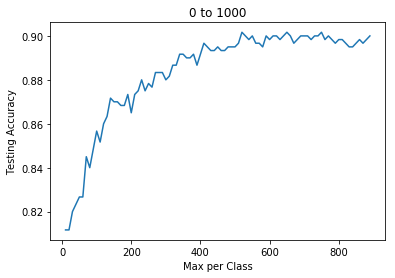

In [57]:
%matplotlib inline 
plt.figure(1);
plt.plot(max_count_per,scores)
plt.xlabel('Max per Class')
plt.ylabel('Testing Accuracy')
plt.title('0 to 1000')
plt.savefig('Sample_size_test.png')

In [21]:
# Split
max_per_test_class = 100
max_per_train_class = 600

sk_data_train, sk_labels_train, sk_data_test, sk_labels_test, train_class_count_dict,test_class_count_dict = sk_train_test_split(max_per_test_class, max_per_train_class, sk_data, sk_labels)

# Data Prep
landcover_train = sk_labels_train[:,0]
canopy_train = sk_labels_train[:,1]
tiles_train = sk_data_train

landcover_test = sk_labels_test[:,0]
canopy_test = sk_labels_test[:,1]
tiles_test = sk_data_test



## SVM (Landcover)

In [49]:
# Grid Search
SVC_parameters = {'kernel': ['linear','rbf','poly'],'C':[0.1, 0.5, 1, 5, 10], 'degree': [1,2,3,4,5], 'gamma': [0.1, 0.01, 0.001, 0.0001]}
SVC_grid = GridSearchCV(SVC(),SVC_parameters,cv = 10, scoring = 'accuracy' ) # might not work, might have to change back to CLF
SVC_grid.fit(tiles_train,landcover_train.astype('int'))

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1, 5, 10], 'degree': [1, 2, 3, 4, 5],
                         'gamma': [0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [51]:
# Best Paramaters
SVC_grid.best_params_

{'C': 10, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [ ]:
# Gamma testing 
gamma_range = range(0.1,1,.05)
scores_gamma = []
for n in gamma_range:
    clf = svm.SVC(kernel = 'rbf', C = 10, gamma = n, degree = 1)
    clf.fit(tiles_train,landcover_train.astype('int'))
    pred_clf = clf.predict(tiles_test)
    scores_gamma.append(accuracy_score(np.argmax(landcover_test,axis = 1), pred_clf_test))

In [56]:
#SVM
clf = svm.SVC(kernel = 'rbf', C = 10, gamma = 0.1, degree = 1)
clf.fit(tiles_train,landcover_train.astype('int'))
pred_clf = clf.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_clf))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_clf))

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       100
           1       0.82      0.91      0.86       100
           2       0.91      0.97      0.94       100
           3       0.93      0.82      0.87       100
           4       0.81      0.74      0.77       100
           5       0.92      0.94      0.93       100

    accuracy                           0.90       600
   macro avg       0.90      0.89      0.89       600
weighted avg       0.90      0.90      0.89       600

Confusion Matrix
[[99  0  0  0  0  1]
 [ 0 91  0  0  9  0]
 [ 0  0 97  0  1  2]
 [ 0  5  3 82  7  3]
 [ 2 15  3  4 74  2]
 [ 0  0  4  2  0 94]]


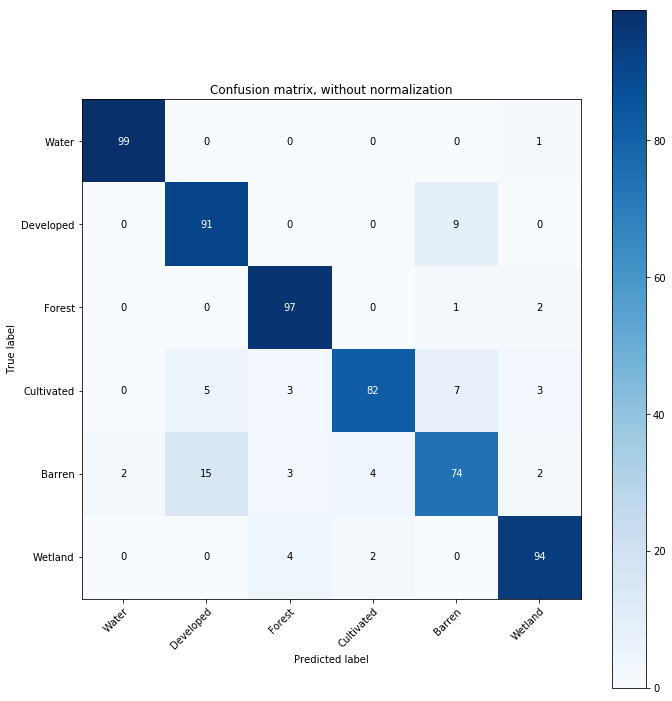

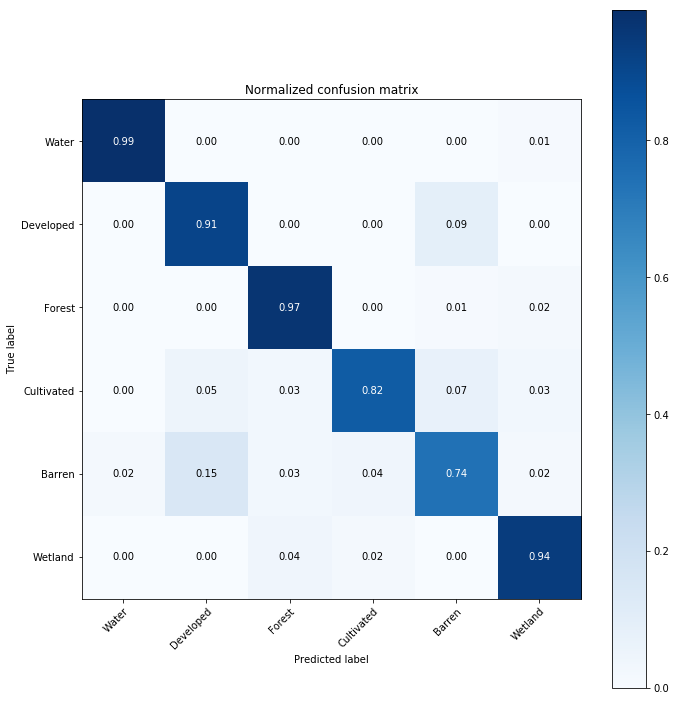

In [64]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
util.plot_confusion_matrix(landcover_test.astype('int'), pred_clf, classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary)
# Plot normalized confusion matrix
util.plot_confusion_matrix(landcover_test.astype('int'), pred_clf, classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary,
                      normalize=True)

# count = 0
# for i in range(len(landover_test)):
#     if(label_index[i] == pred_index[i]):
#         count+=1
# print("Accuracy is {}".format(count/len(label_index)))

plt.savefig("confusion_matrix.png", dpi=1000)

## RFC (Landcover)

In [93]:
RFC_parameters = { 
    'n_estimators': [180],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,11,12,13,14,15],
    'criterion' :['gini', 'entropy']
}
RFC_grid = GridSearchCV(rfc,RFC_parameters,cv = 10, scoring = 'accuracy' )
RFC_grid.fit(tiles_train,landcover_train.astype('int'))

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [69]:
RFC_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'max_features': 'auto',
 'n_estimators': 350}

In [95]:
# RFC Neighbor Testing
n_range = range(1,1000,10)
scores_n = []
for n in n_range:
    rfc_test = RandomForestClassifier(criterion = 'entropy', max_depth = 11, max_features = 'auto', n_estimators = n)
    rfc_test.fit(tiles_train, landcover_train.astype('int'))
    pred_rfc_test = rfc_test.predict(tiles_test)
    scores_n.append(accuracy_score(landcover_test.astype('int'), pred_rfc_test))

Text(0.5, 1.0, '100 to 300')

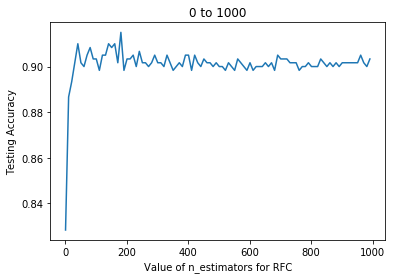

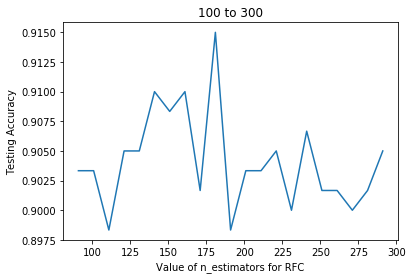

In [100]:
# RFC Testing Plot
%matplotlib inline 
plt.figure(1);
plt.plot(n_range,scores_n)
plt.xlabel('Value of n_estimators for RFC')
plt.ylabel('Testing Accuracy')
plt.title('0 to 1000')

plt.figure(2)
plt.plot(n_range[9:30],scores_n[9:30])
plt.xlabel('Value of n_estimators for RFC')
plt.ylabel('Testing Accuracy')
plt.title('100 to 300')

In [101]:
#RFC
rfc = RandomForestClassifier(criterion = 'entropy', max_depth = 11, max_features = 'auto', n_estimators = 180)
rfc.fit(tiles_train,landcover_train.astype('int'))
pred_rfc = rfc.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_rfc))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_rfc))


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       100
           1       0.88      0.92      0.90       100
           2       0.89      0.95      0.92       100
           3       0.89      0.90      0.90       100
           4       0.85      0.73      0.78       100
           5       0.94      0.94      0.94       100

    accuracy                           0.91       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.91      0.90       600

Confusion Matrix
[[99  0  0  0  0  1]
 [ 0 92  0  0  8  0]
 [ 0  0 95  2  2  1]
 [ 0  0  3 90  3  4]
 [ 2 13  5  7 73  0]
 [ 0  0  4  2  0 94]]


## KNN (Landcover)

In [74]:
# KNN Neighbor Testing
k_range = range(1,100)
scores = []
for k in k_range:
    knn_test = KNeighborsClassifier(n_neighbors = k)
    knn_test.fit(tiles_train,landcover_train.astype('int'))
    pred_knn_test = knn_test.predict(tiles_test)
    scores.append(accuracy_score(landcover_test.astype('int'),pred_knn_test))
    

Text(0.5, 1.0, '15 to 35')

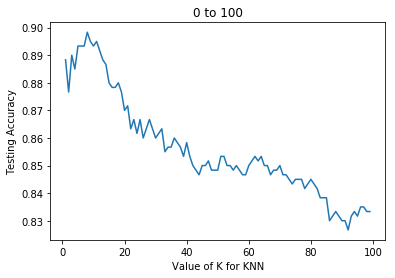

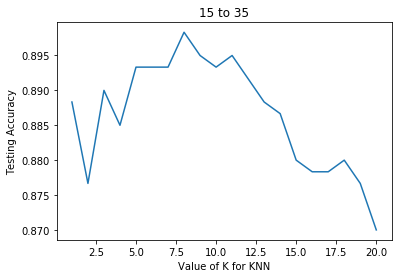

In [76]:
# KNN Testing Plot
%matplotlib inline 
plt.figure(1);
plt.plot(k_range,scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.title('0 to 100')


plt.figure(2);
plt.plot(k_range[0:20],scores[0:20])
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.title('15 to 35')

In [77]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(tiles_train,landcover_train.astype('int'))
pred_knn = knn.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_knn))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_knn))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       100
           1       0.84      0.92      0.88       100
           2       0.90      0.96      0.93       100
           3       0.95      0.83      0.89       100
           4       0.84      0.74      0.79       100
           5       0.90      0.95      0.92       100

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600

Confusion Matrix
[[99  0  0  0  0  1]
 [ 0 92  0  0  7  1]
 [ 0  0 96  0  2  2]
 [ 0  3  4 83  4  6]
 [ 3 15  4  3 74  1]
 [ 0  0  3  1  1 95]]


## K-means

In [81]:
k_means = KMeans(n_clusters = 6)
k_means.fit(tiles_train,landcover_train.astype('int'))
pred_k_means = k_means.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_k_means))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_k_means))

Classification Report
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       100
           1       0.31      0.11      0.16       100
           2       0.00      0.00      0.00       100
           3       0.53      0.82      0.65       100
           4       0.05      0.11      0.07       100
           5       0.00      0.00      0.00       100

    accuracy                           0.34       600
   macro avg       0.30      0.34      0.30       600
weighted avg       0.30      0.34      0.30       600

Confusion Matrix
[[100   0   0   0   0   0]
 [  0  11  43  40   5   1]
 [  0   0   0   2  98   0]
 [  0   1   6  82  11   0]
 [  3  23  40  23  11   0]
 [ 11   0   0   7  82   0]]


## Mean Shift

In [91]:
mean_shift = MeanShift()
mean_shift.fit(tiles_train,landcover_train.astype('int'))
pred_mean_shift = mean_shift.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_mean_shift))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_mean_shift))

Classification Report
              precision    recall  f1-score   support

           0       0.19      0.99      0.32       100
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.03      0.02      0.02       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100
           8       0.00      0.00      0.00         0

    accuracy                           0.17       600
   macro avg       0.03      0.14      0.05       600
weighted avg       0.04      0.17      0.06       600

Confusion Matrix
[[ 99   0   0   0   0   0   1]
 [ 70   0   3  26   1   0   0]
 [100   0   0   0   0   0   0]
 [ 98   0   0   2   0   0   0]
 [ 48   0   1  51   0   0   0]
 [100   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Adding Landcover to Training Data

In [137]:
landcover_train_altered =[10,10,10,10,10,10]
for x in landcover_train:
    adding = [0,0,0,0,0,0]
    adding[x] = 1
    landcover_train_altered = np.vstack([landcover_train_altered,adding])

landcover_test_altered =[10,10,10,10,10,10]
for x in landcover_test:
    adding = [0,0,0,0,0,0]
    adding[x] = 1
    landcover_test_altered = np.vstack([landcover_test_altered,adding])


landcover_train_altered = landcover_train_altered[1:]
landcover_test_altered = landcover_test_altered[1:]

new_tiles_train = np.concatenate((tiles_train,landcover_train_altered), axis = 1)
new_tiles_test = np.concatenate((tiles_test, landcover_test_altered), axis = 1)
new_tiles_train.shape, new_tiles_test.shape

((3600, 34), (600, 34))

In [144]:
landcover_train_altered =[100]
for x in landcover_train:
    adding = [x]
    landcover_train_altered = np.vstack([landcover_train_altered,adding])

landcover_test_altered =[100]
for x in landcover_test:
    adding = [x]
    landcover_test_altered = np.vstack([landcover_test_altered,adding])


landcover_train_altered = landcover_train_altered[1:]
landcover_test_altered = landcover_test_altered[1:]

new_tiles_train2 = np.concatenate((tiles_train,landcover_train_altered), axis = 1)
new_tiles_test2 = np.concatenate((tiles_test, landcover_test_altered), axis = 1)
new_tiles_train2.shape, new_tiles_test2.shape

((3600, 29), (600, 29))

## Linear Regression (Canopy)

#### Normal Training Tiles

Mean Absolute Error: 0.1276159045211324
Mean Squared Error: 0.027582342867466074
Root Mean Squared Error: 0.16607932703219289


Text(0.5, 1.0, 'Linear Regression')

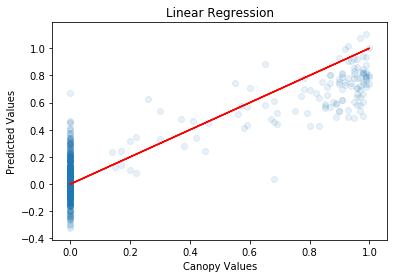

In [14]:
LR = LinearRegression()
LR.fit(tiles_train,canopy_train)
predLR = LR.predict(tiles_test)

print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, predLR))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, predLR))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test,predLR)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, predLR, alpha = .1)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression')

#### Training Tiles With Landcover Data

Mean Absolute Error: 0.06620250057195093
Mean Squared Error: 0.010700136117180075
Root Mean Squared Error: 0.10344146227301737


Text(0.5, 1.0, 'Linear Regression')

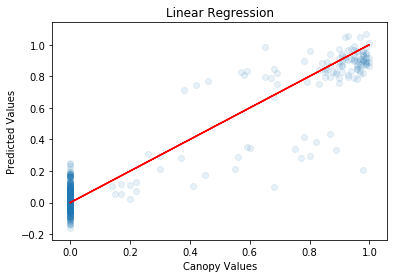

In [139]:
LR_landcover = LinearRegression()
LR_landcover.fit(new_tiles_train,canopy_train)
predLR_landcover = LR.predict(new_tiles_test)

print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, predLR_landcover))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, predLR_landcover))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test,predLR_landcover)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, predLR_landcover, alpha = .1)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression')

## Lasso (Canopy)

Mean Absolute Error: 0.18273296346564818
Mean Squared Error: 0.059066888704397004
Root Mean Squared Error: 0.24303680524644206


Text(0.5, 1.0, 'Lasso')

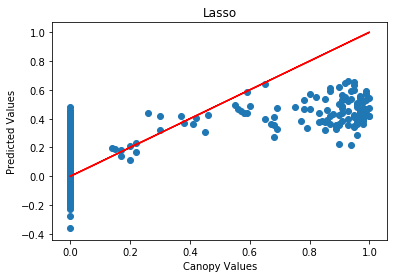

In [15]:
las= Lasso(alpha = 0.05)
las.fit(tiles_train,canopy_train)
predLas = las.predict(tiles_test)


print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, predLas))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, predLas))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test, predLas)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, predLas)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Lasso')

## Random Forest Regression

#### Normal Training Tiles

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute Error: 0.031293333333333326
Mean Squared Error: 0.006128743333333332
Root Mean Squared Error: 0.0782862908390309


Text(0.5, 1.0, 'Random Forest Regression')

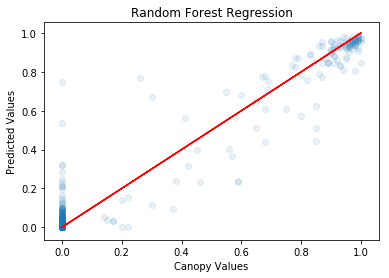

In [16]:
rfr = RandomForestRegressor()
rfr.fit(tiles_train,canopy_train)
pred_rfr = rfr.predict(tiles_test)

print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, pred_rfr))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, pred_rfr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test,pred_rfr)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, pred_rfr, alpha = .1)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression')

#### Training Tiles With Landcover Data

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute Error: 0.029378333333333336
Mean Squared Error: 0.004961858333333334
Root Mean Squared Error: 0.0704404594912138


Text(0.5, 1.0, 'Random Forest Regression')

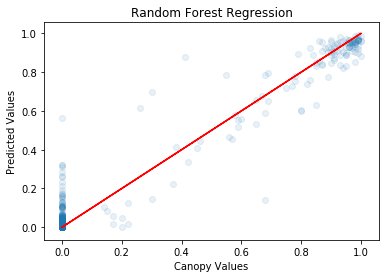

In [148]:
rfr_landcover = RandomForestRegressor()
rfr_landcover.fit(new_tiles_train,canopy_train)
pred_rfr_landcover = rfr_landcover.predict(new_tiles_test)

print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, pred_rfr_landcover))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, pred_rfr_landcover))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test,pred_rfr_landcover)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, pred_rfr_landcover, alpha = .1)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression')